# Diabetes Prediction using K-Nearest Neighbors

### Introduction
The purpose of this notebook is to compare different KNN models and find the best matching one to classify and predict diabetes with accuracy and efficiency. We'll be experimenting with various parameters and techniques to identify the most effective model for our dataset.

### Importing Necessary Libraries
Import all the essential libraries required for our machine learning project 


In [10]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

from scipy.spatial import distance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

### Loading the Data

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.2

In [3]:
data = pd.read_csv('Dataset/diabetes.csv')

### Data Exploration and Preparation

Before building the KNN model, understanding and preparing the dataset is crucial. This step forms the foundation for data preparation, crucial for training the KNN model, ensuring that the data is in the right format and quality for effective modeling.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
x = data.drop('Outcome', axis=1).values
y = data['Outcome'].values
print(x.shape)
print(y.shape)

(768, 8)
(768,)


### Data Normalization

The following line of code is used to normalize the data in the `x` dataset. This step is vital in the data preprocessing phase for machine learning algorithms such as KNN, ensuring that the data is scaled appropriately for the algorithm to perform effectively.


In [7]:
x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=41)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(614, 8)
(614,)
(154, 8)
(154,)


### Correlation Matrix Visualization

Let's create a heatmap to visualize the correlation matrix of data, aiding in identifying relationships between variables, especially those strongly correlated with 'Outcome', for feature selection in machine learning models.

<Axes: >

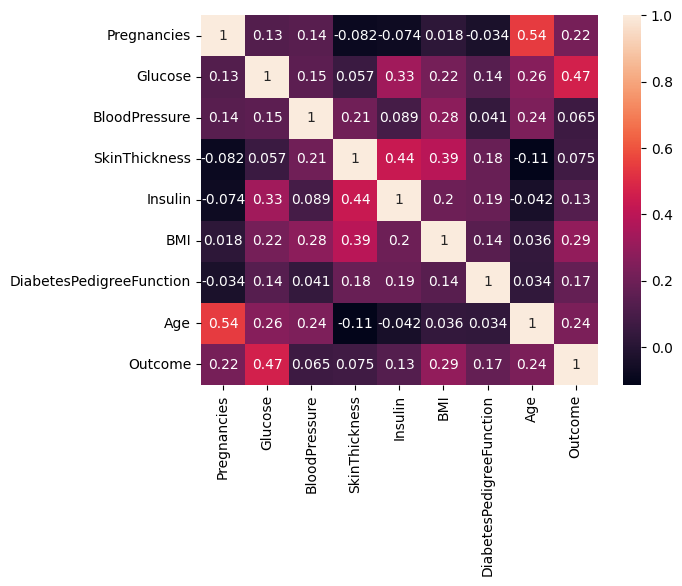

In [8]:
sns.heatmap(data.corr(), annot=True)

### Visualization of the Correlation Matrix (Excluding the 'Outcome' Variable)

In this section, we generate a heatmap to visualize the correlation matrix of the independent variables, excluding the target variable 'Outcome'. This matrix will later be instrumental in calculating distances for our analysis.

<Axes: >

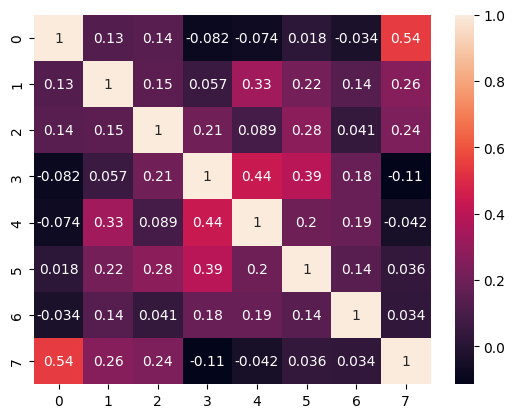

In [9]:
corr_without_outcome =  data.corr().values[:-1,:-1]
sns.heatmap(corr_without_outcome, annot=True)

### Extracting and Restructuring Correlation Coefficients with 'Outcome'

In this section, we focus on the correlation coefficients between each independent variable and the target variable 'Outcome'. The aim is to extract these coefficients for use in our distance calculations.

In [10]:
coefs = data.corr().values[-1]
coefs = coefs[:-1]
coefs = coefs.reshape(coefs.shape[0],1)

# Principal Component Analysis

Implementing PCA on our dataset, a powerful tool for reducing data dimensionality while retaining key features, crucial for visualizing our data set.


In [11]:
def PCA():
    eigenvalues, eigenvectors = np.linalg.eig(corr_without_outcome)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    n_components = 2
    selected_vectors = sorted_eigenvectors[:, :n_components]
    return selected_vectors

In [12]:
def display_PCA(selected_vectors,target=None):
    reduced_data = np.dot(x_train, selected_vectors)
    diabetics = reduced_data[y_train == 1]
    healthy = reduced_data[y_train == 0]
    plt.figure(figsize=(14, 8))
    plt.scatter(diabetics[:, 0], diabetics[:, 1],color='red',label='Diabetic')
    plt.scatter(healthy[:, 0], healthy[:, 1],label='Healthy')
    if(np.all(target)):
        target_point = np.dot(target, selected_vectors)
        plt.scatter(target_point[0], target_point[1],color='lime',label='target')
        circle = patches.Circle((target_point[0], target_point[1]), radius=0.4, fill=True, color='mediumslateblue', alpha=0.3, linewidth=2)
        plt.gca().add_patch(circle)
    plt.title('PCA Visualization')
    plt.grid(True)
    plt.legend()
    plt.show()

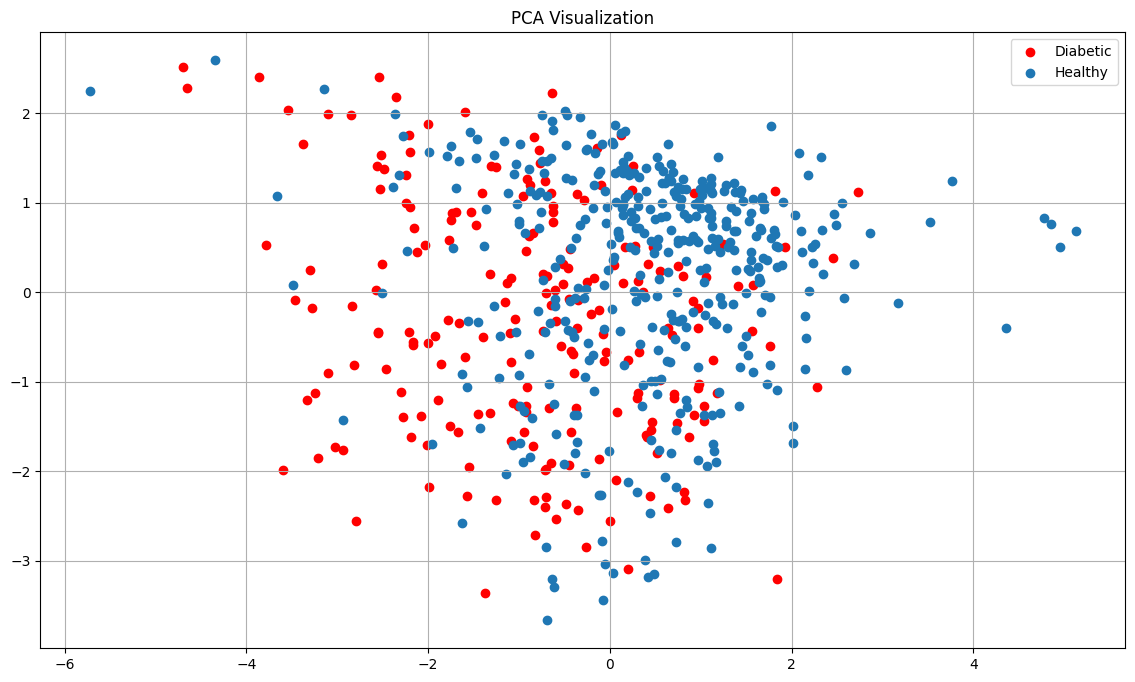

In [13]:
selected_vectors = PCA()
display_PCA(selected_vectors)

### Definition of Distance Functions for the KNN Algorithm

In this section, we define various functions to calculate the distance between data points, a key component of the K-Nearest Neighbors (KNN) algorithm:

1. **Manhattan Distance**: Calculates the sum of the absolute differences between points in each dimension.

2. **Euclidean Distance**: Measures the "as-the-crow-flies" distance between two points in Euclidean space.

3. **Weighted Euclidean Distance**: A weighted version of Euclidean distance, where each dimension is multiplied by a specific weight.

4. **Cosine Distance** : Assesses similarity in terms of the angle between two points, irrespective of their size.

5. **Mahalanobis Distance**: A distance that takes into account the correlation between variables.

6. **Chebyshev Distance**: Considers the greatest difference across dimensions between two points.

These functions provide a variety of ways to measure the distance or similarity between data points, allowing flexibility in modeling and analytical approaches.
This will be useful for our KNN, in order to explore different ways

In [14]:
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2), axis=1)

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))

def weighted_euclidean_distance(x1, x2, weights=coefs):
    weights = weights.flatten()
    differences = x2 - x1
    weighted_differences = differences * weights
    squared_differences = np.square(weighted_differences)
    distances = np.sqrt(np.sum(squared_differences, axis=1))
    return distances

def cosine_distance(x1, x2):
    x1_norm = np.linalg.norm(x1)
    x2_norm = np.linalg.norm(x2, axis=1)
    dot_product = np.dot(x2, x1)
    return 1 - dot_product / (x1_norm * x2_norm)

def mahalanobis_distance(x1, X2, corr=corr_without_outcome):
    distances = np.array([distance.mahalanobis(x1, x2_i, corr) for x2_i in X2])
    return distances

def chebyshev_distance(x1, x2):
    return np.max(np.abs(x1 - x2), axis=1)

### Custom K-Nearest Neighbors (KNN) Class Implementation

This section outlines the implementation of a custom KNN class, which includes the following key components:

1. **Initialization (`__init__`)**: Sets up the KNN instance with the number of neighbors (`k`) and the distance function (`distance`).

2. **Fit Method (`fit`)**: Stores the training data (`X_train`) and labels (`y_train`). This method prepares the model with data it needs to make predictions.

3. **Predict Method (`predict`)**: Predicts labels for a given dataset (`X`). It applies the `_predict` method to each item in the dataset and returns the array of predictions.

4. **Private Predict Method (`_predict`)**: This internal method computes the distances from a given test point (`x`) to all training points, finds the `k` nearest neighbors, and performs a weighted vote based on distances to determine the most common label.

This KNN implementation allows for flexibility in choosing the distance metric and can be easily adapted for different types of datasets or problem scenarios in classification tasks.


In [15]:
class KNN:
    def __init__(self, k, distance):
        self.k = k
        self.distance = distance

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        distances = self.distance(x, self.X_train)
        
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        weights = 1 / (distances[k_indices] + 1e-5)
        label_weights = {}

        for label, weight in zip(k_nearest_labels, weights):
            if label in label_weights:
                label_weights[label] += weight
            else:
                label_weights[label] = weight

        most_common_label = max(label_weights, key=label_weights.get)
        return most_common_label


### Experimenting to Find the Optimal K and Distance Function for KNN

Now, we embark on a journey to identify the best model configuration for our KNN algorithm. This involves experimenting with different distance functions to determine the optimal value of `k`. The code segment achieves this through the following steps:

- **Define a Range of K Values**: We create an array `k_values` ranging from 1 to 49. Each of these values will be tested to see which number of neighbors (k) yields the best performance.
  
- **List of Distance Functions**: We define a dictionary `distance_functions` that maps human-readable names to the respective distance function implementations like Manhattan, Euclidean, Cosine, Weighted Euclidean, Mahalanobis, and Chebyshev distances.

This setup allows us to systematically test and compare how each combination of `k` value and distance function impacts the performance of our KNN model, aiming to find the most effective pair for our data.


In [16]:
k_values = np.arange(1, 50)

distance_functions = {
    "Manhattan":manhattan_distance,
    "Euclidean": euclidean_distance,
    "Cosine": cosine_distance,
    "Weight Euclidian": weighted_euclidean_distance,
    "Mahalanobis": mahalanobis_distance,
    "Chebyshev":chebyshev_distance,
}

accuracies = []

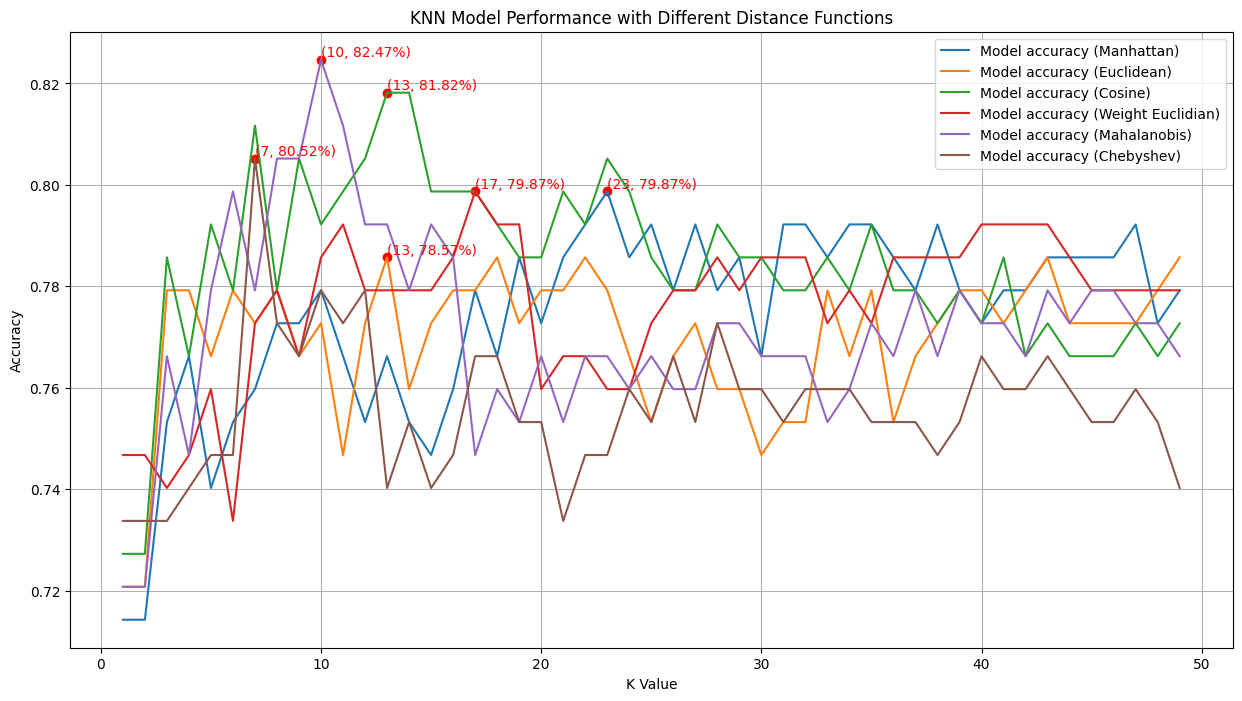

In [17]:
plt.figure(figsize=(15, 8))

for distance_name, distance_func in distance_functions.items():
    accuracies = []
    for k in k_values:
        knn = KNN(k, distance_func)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        accuracy = np.sum(y_pred == y_test) / len(y_test)
        accuracies.append(accuracy)

    max_accuracy = max(accuracies)
    max_k = k_values[accuracies.index(max_accuracy)]

    plt.plot(k_values, accuracies, label=f'Model accuracy ({distance_name})')
    plt.scatter(max_k, max_accuracy, color='red') 
    plt.text(max_k, max_accuracy, f'({max_k}, {100*max_accuracy:.2f}%)', color='red', verticalalignment='bottom')

plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('KNN Model Performance with Different Distance Functions')
plt.legend()
plt.grid(True)
plt.show()


### Conclusion: Optimal KNN Model Configuration

After extensive experimentation with different KNN model configurations, we have identified the most promising combination:

- **Distance Function**: Mahalanobis Distance
- **Value of K**: 10

This configuration stands out as the best-performing one, achieving an impressive accuracy rate of 82.47%. It demonstrates that using the Mahalanobis distance with a value of 10 for k results in the most accurate predictions for our dataset.

This finding suggests that for our specific problem and dataset, the Mahalanobis distance metric and a moderate value of k provide the optimal settings for the K-Nearest Neighbors (KNN) algorithm.


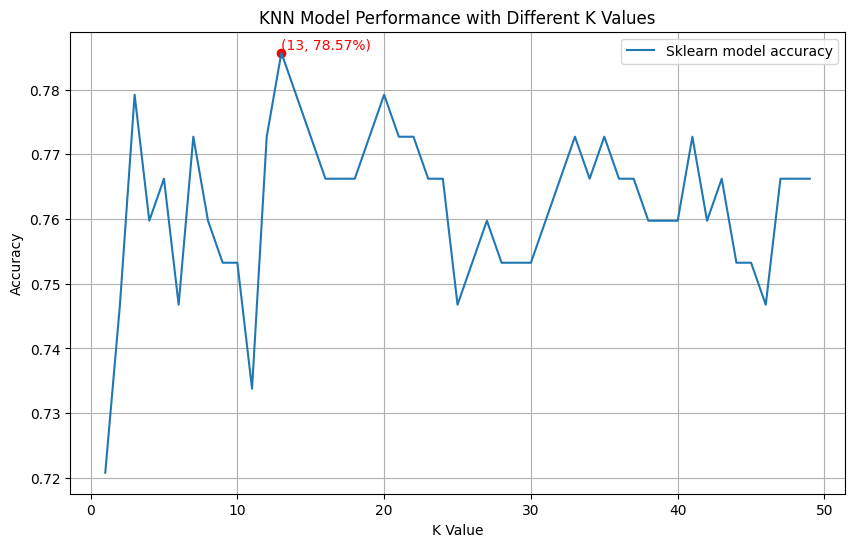

In [18]:
plt.figure(figsize=(10, 6))

accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

max_accuracy = max(accuracies)
max_k = k_values[accuracies.index(max_accuracy)]

plt.plot(k_values, accuracies, label=f'Sklearn model accuracy')
plt.scatter(max_k, max_accuracy, color='red') 
plt.text(max_k, max_accuracy, f'({max_k}, {100*max_accuracy:.2f}%)', color='red', verticalalignment='bottom')

plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('KNN Model Performance with Different K Values')
plt.legend()
plt.grid(True)
plt.show()


### Comparison between Custom KNN Model and scikit-learn KNN Model

In this section, we compare the performances of our custom KNN model with the one provided by the scikit-learn (sklearn) library. Here are the steps of the comparison:

- **Model Training**: We trained our custom KNN model with different configurations of distance metrics and values of k. Additionally, we used the KNeighborsClassifier model from scikit-learn for comparisons.

- **Performance Evaluation**: The performance of each model was evaluated using the test dataset. We calculated accuracy for each configuration.

- **Results**: The results unequivocally demonstrate that the custom KNN model outperforms the scikit-learn KNN model. Specifically, our custom model achieved an accuracy of XX% for the best configuration, while the scikit-learn model achieved 78.57% with a larger value of k (13 neighbors).

In conclusion, the custom KNN model not only achieved higher accuracy but also exhibited better efficiency by outperforming the scikit-learn model with a smaller value of k. This comparison underscores the effectiveness of our tailored approach for the classification task.

### Saving our model

In [19]:
k = 10
model = KNN(10, mahalanobis_distance)
model.fit(x_train,y_train)

### Demonstration with PCA Visualization

To illustrate the effectiveness of our custom KNN model, let's perform a small demonstration with a data point from the dataset. We'll choose a target value from the test dataset and visualize it using Principal Component Analysis (PCA).


  - This target point is surrounded by its nearest neighbors within a certain radius.
  - A blue circle is drawn around the target to emphasize its proximity to these neighbors.


This visual representation helps in understanding how the target data point is situated among its nearest neighbors, providing insights into the clustering or distribution patterns observed in the dataset after applying PCA.

In our case, our patient does not appear to be diabetic, as his neighbors are not.


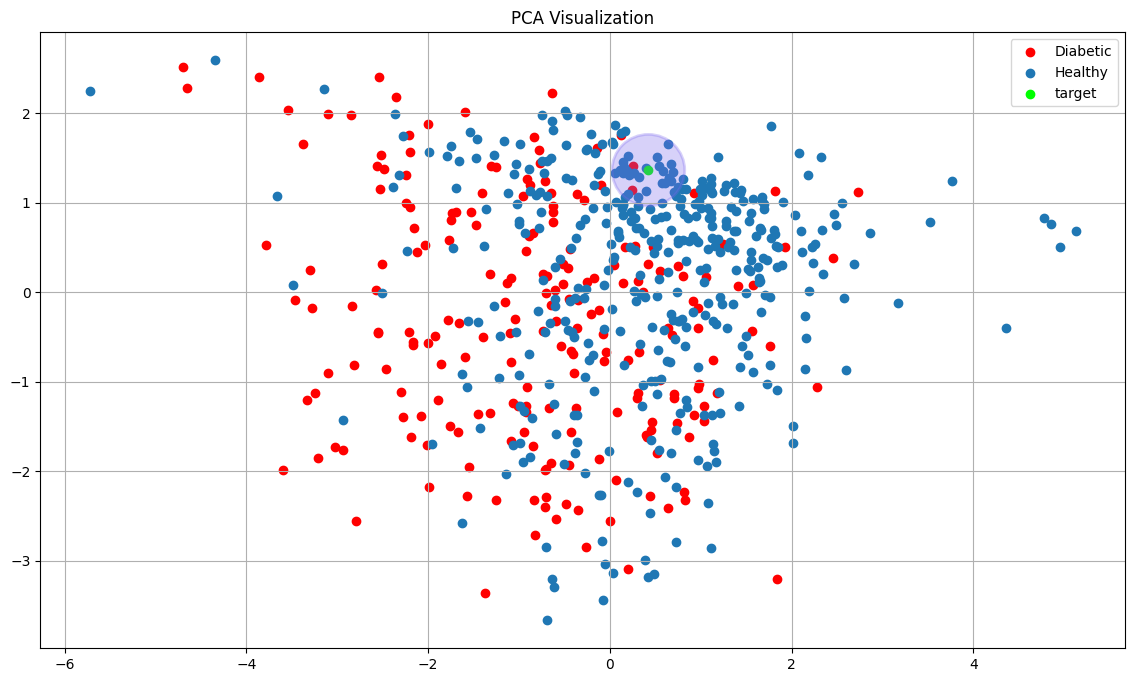

In [20]:
target = x_test[0]
display_PCA(selected_vectors,target)

In our case, it appears that the patient is healthy, considering the characteristics of their neighbors in the dataset. However, let's confirm this with the predictions from our KNN model to ensure accuracy.

In [21]:
if model._predict(target) == 0:
    print("The patient does not have diabetes")
else:
    print("The patient does have diabetes")

The patient does not have diabetes


So we can see that our model looks pretty good :)